# Feature Selection Notebook (nyi malik et nour)

Use this template notebook to try a FeatureExtractor and test it on different simple models

In [1]:
from problem import get_train_data, get_test_data
import matplotlib.pyplot as plt

/Users/nour/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Loading data
X, y = get_train_data()
#X_test, y_test = get_test_data()

[ 38  47  38 ... 131  64  52]


In [3]:
class FeatureExtractor():
    def __init__(self):
        pass

    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        return X_df

In [4]:
from sklearn.base import BaseEstimator
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from sklearn.naive_bayes import GaussianNB

import numpy as np

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = GaussianNB()
    
    def fit(self, X, y):
        self.clf.fit(X, y)
        
    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        y_pred_proba = self.clf.predict_proba(X)
        return y_pred_proba


Using TensorFlow backend.


# Testing

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from problem import AUTR

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [7]:
model = make_pipeline(FeatureExtractor(), Classifier())

In [8]:
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('featureextractor', <__main__.FeatureExtractor object at 0x1a2eab6eb8>), ('classifier', Classifier())])

In [9]:
predictions = model.predict_proba(X_valid)

In [10]:
scorer = AUTR()
print("Area Under The Rank : "+str(scorer(y_valid, predictions)))

Area Under The Rank : 72136


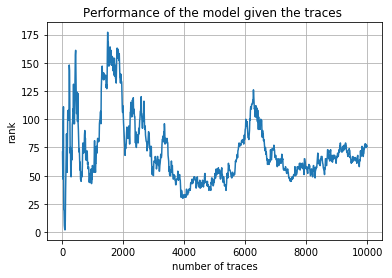

In [13]:
ranks = scorer.rankings

x = [ranks[i][0] for i in range(0, ranks.shape[0])]
y = [ranks[i][1] for i in range(0, ranks.shape[0])]
plt.title('Performance of the model given the traces ')
plt.xlabel('number of traces')
plt.ylabel('rank')
plt.grid(True)
plt.plot(x, y)
plt.show()
plt.figure()